# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=74)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 6375, 'TN': 59590, 'FP': 55059, 'FN': 6632, 'Accuracy': 0.5167403020617911, 'Precision': 0.1037698994042387, 'Recall': 0.49012070423618054, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12956, 'TN': 114596, 'FP': 53, 'FN': 51, 'Accuracy': 0.999185310522028, 'Precision': 0.9959258974556077, 'Recall': 0.9960790343661106, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12935, 'TN': 114598, 'FP': 51, 'FN': 72, 'Accuracy': 0.9990364730212445, 'Precision': 0.9960726936701063, 'Recall': 0.9944645191050973, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12749, 'TN': 103299, 'FP': 11350, 'FN': 258, 'Accuracy': 0.9090681205740427, 'Precision': 0.5290261006680775, 'Recall': 0.9801645267932652, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12912, 'TN': 114566, 'FP': 83, 'FN': 95, 'Accuracy': 0.9986056276242401, 'Precision': 0.9936129280492497, 'Recall': 0.9926962404858922, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 11769, 'TN': 114457, 'FP': 192, 'FN': 1238, 'Accuracy': 0.9887980196778843, 'Precision': 0.9839478304489592, 'Recall': 0.9048204812793111, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 0, 'TN': 114649, 'FP': 0, 'FN': 13007, 'Accuracy': 0.8981089803847842, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

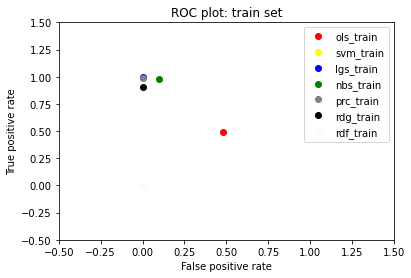

In [52]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

'''
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
'''

colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.5, 1.5, -0.5, 1.5])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [53]:
ols_predictions = ols.predict(X_train)

In [54]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
5
"

lord Shiva for Featured article 
I just see many important features relating to the topic was missing, including a small description and link to Maha Shivaratri .       I would like to give my points here.Undoubtedly lord Shiva is linked to all sections and regions of the Indian society.There are great works relating to lord Shiva in many languages. Remember he is pre vedic god, immensely popular among tribes later on included in the Vedas. If the page depicts what is in popular culture it will be a great source and the page should become ""Featured Article"". I feel there is discrimination of users writing from Tamil / Malayalam / Kannada even Hindi perspective. Sanskrit has its own credits, it is unique and as the name suggests it is ""well written"". I have written 4 articles on them. But it gets defamed by wrong promoters who make it mess up with other languages / claiming other linguistic works. My article was edited because i mentioned the name o

4159
"
The language used is Antisemitic. It's you that's deducing that your Wiki red associate is an Antisemite. So if you want him saved from personal attack, I suggest you keep is name out of our discussion. However, I notice that you are working with, and being carefully advised by  "
* * * * * * * * * 
4187
Copyright Notice

The text of this pageis available for modification and reuse under the terms of the Creative Commons Attribution-Sharealike 3.0 Unported License and the GNU Free Documentation License.

You are free:
- to Share — to copy, distribute and transmit the work, and
- to Remix — to adapt the work

Under the following conditions:

- Attribution — You must attribute the work in the manner specified by the author or licensor (but not in any way that suggests that they endorse you or your use of the work.) You must maintain a link to this article (http://www.greatchefs.com/chris-yeo/)

- Share Alike — If you alter, transform, or build upon this work, you may distribute th

9185
Thanks for the clarification and explanation.
* * * * * * * * * 
9210
2010 (UTC)
 Yes, like adding to Karl Marx's article that Marx is the link between Luther and Hitler.  12:16, 2 June
* * * * * * * * * 
9221
"
 

Welcome to Wikipedia

Hello, , and welcome to Wikipedia! Wikipedia is one of the world's fastest growing internet sites. We aim to build the biggest and most comprehensive encyclopaedia in the world. To date we have over four million articles in a host of languages. The English language Wikipedia alone has over one million articles! But we still need more! Please feel free to contribute your knowledge and expertise to our site. 

If you need help see:
Help contents - the main help page.
Cheatsheet - a listing of the main editing commands.

Here are a few more good links for newcomers:
The five pillars of Wikipedia
How to edit a page
Tutorial
How to write a great article
Manual of Style
Category:WelcomeBotResearch
We hope you enjoy editing here and being a Wikipedian! Pl

14320
How in the world is that statement worthy of a two day block? TreasuryTag files a misleading, half-complete WQA (after a day's worth of baiting and smiling incivility) and when I respond, I get blocked? Are you kidding me?
* * * * * * * * * 
14361
"
Holy Roman Empire doesn't mean we were Germans or belonged to Germany. Your arrogance is terrible. ≈talk≈ "
* * * * * * * * * 
14416
"trampoline article]]. The current focus of the article fails to Provide context for the reader (it should ""state facts which may be obvious to you, but are not necessarily obvious to the reader"", such that programming languages are about programming). 
And your involvement in keeping the status quo based just in that opinion of yours is not helping to reach consensus about my concerns. I don't want to cite here all relevant Wikipedia policies that would support my posture about generalizing the current focus of the article, just notice that your opinion about what this article should be is IMO not wha

18687
if you don't get your way
* * * * * * * * * 
18707
"

 Talk:Presidency of Barack Obama 

What is your rationale behind removing the comment on Talk:Presidency of Barack Obama ()? I don't see anything that violates talk page guidelines, the editor that made it had a legitimate question about article content. '''''' (TALK) "
* * * * * * * * * 
18757
By the way, I created today Project Rachel because I saw the red link in your article. May be you would like to help expand it. Regards.
* * * * * * * * * 
18775
"

 Wikihounding 101 

""Third, you are a reprehensible little man. You just called me a liar but at least I don't come to several pages, which in itself is against policy if not common sense, and make accusations because someone accuses you of adding information without references. That's worse than wikihounding, but it is a form of it. When you go to my talk page and make veiled accusations there, when they belong at the appropriate discussion that's clearly wikihounding. You

22659
Freak added a link that displayed my street address, and I deleted it because the PO box is sufficient, and already widely available. Then someone else added a box from NameBase with my telephone and fax numbers, whereupon I had to edit out the numbers on the box at NameBase. I don't need BLP victims calling me up and complaining that the Wikimedia office ignores them (this already happened today)! If Freak wants to do something useful, he can delete the page and all the archive pages at Talk:Daniel_Brandt. By the way, Jimbo unblocked me the same time that he semi-protected the PIR article. He was protecting it against trolls that hate me. He wasn't semi-protecting the article because of my edit.
* * * * * * * * * 
22666
You don't know what you are talking about, . That website references a HISTORICAL item from 1981. It is NOT an advertisement for Woodbrooke Estates. Get your facts straight before needlessly editing something that you know NOTHING about!
* * * * * * * * * 
22705


27197
"

Speedy deletion of Nerevarine
 Please refrain from introducing inappropriate pages such as Nerevarine, to Wikipedia. Doing so is not in accordance with our policies. If you would like to experiment, please use the sandbox 

If you think that this notice was placed here in error, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the talk page explaining your position, but be aware that once tagged for speedy deletion, if the article meets the criterion it may be deleted without delay. Please do not remove the speedy deletion tag yourself, but don't hesitate to add information to the article that would would render it more in conformance with Wikipedia's policies and guidelines.   ''talk ♦ contribs''  "
* * * * * * * * * 
27199
"

The Silver Chair
Ok so someone thinks that ""The Chronicles of Narnia: The Silver Chair"" should be merged into this thread. Seriously, why bother doing

31635
Well what I was trying to say is it isn't just in the policies. We have to be able to step back and see an encyclopedia article when it is all done. Hmm, I wonder if there is a WP:GESTALT? =)
* * * * * * * * * 
31641
Thanks! 
Sir, I justed wanted to express my appreciation for your willingness to ask fair questions in the discussion addressing the issues raised against me. Your willingness to demand reasoned and logical arguments and not just settle for loose explanations is welcomed. I know it takes more time to read all posts and realize there may be holes in one's arguments. I also wish to express thanks for the thoughtful consideration of fellow admins , ,  and . Thanks!
* * * * * * * * * 
31650
"

 Stephanie Adams 

Left a post for you, I've done ALOT of research on this chick, she has NO pr people here , and never has, read the comment on her talk page that was ""mysteriously"" reverted. I have talked to her on the phone as she had a tv blaring and was drinking and talking 

36112
"

Perhaps someone can say something more detailed about her abilities: is there some metaphysical account of how they ""operate""? And, an analysis of their use as a plot device might also be nice. xx

"
* * * * * * * * * 
36133
"

Good work. The article has progressed, and we are very close to listing. The areas that need attention are a) Building the lead to give an appropriately detailed summary of the article, sufficient to provide the general reader with a satisfactory overview - this is the priority; b) Trimming some unnecessary detail; c) Including some detail on the other men arrested - this is minor, and I wouldn't quibble if it wasn't done. I think all this is quite achievable in a few days, and I'm willing to help out on the work. I would hope that the article can be listed before the end of next week. ''' ✔Tea time''' "
* * * * * * * * * 
36157
Well, mea clupa. Unfortunately I mixed it up )
* * * * * * * * * 
36250
As the person who placed some of the warnings, I can

40769
Your remarks 

The content you were debating on Volksdeutsche article was not the edit that I made today. I suggest you be more carefull with threats of sanctions,
* * * * * * * * * 
40821
Ask younus Harami to start counting days.
* * * * * * * * * 
40852
I know someone who was banned for that. Do you have any info on Estonia? I have a friend who is Estonian and he claims there are only around fifteen hundred left. I understand that in Eastern Europe Estonians are known for their abilitys as spies. Is this the case?(username witheld as user is currently banned)
* * * * * * * * * 
40890
Hi Neuromancer,

You will never get anywhere with the likes of Keepcalmandcarryon, Mastcell, Nunh-huh, etc. Going into the archives of some of the articles here on AIDS and HIV, I found that some of these people have been working, full-time it seems, on keeping these pages biased for years, and that they don't allow any edits which provide alternative information to the orthodox theory that HIV=AID

45230
Zapp Brannigan 

This is no place for fanfics. You know very well that Zapp doesn't go spiraling out into space when Kif punches him in The Beast with a Billion Backs, and that the only makes one or two non-speaking cameos in Bender's Game. Immblueversion
* * * * * * * * * 
45323
"

 Technical limitations reached on this article 

In case you hadn't noticed, a large number of templates aren't getting displayed on this page.  Looking at the page source, the following text appears quite a few times...
 

When this happens, the template isn't rendered, but simply displayed as a link to the template.  I think the problem is in the multiple infoboxes here and their calls to all the route diagram templates pushing up the template count.  So, what do we split out to another article to resolve this problem?  My first thought would be to put the route information for each of the three routes listed into their own articles, since that's where the route diagrams make the most sense.  (Speak

49922
Fellow, user. Can karma your ovaries.Users. Brooms Illegally track car houses (BTW: Read every first letter of the words)((IM USING A PROXY)) 91.73.192.51
* * * * * * * * * 
49941
"

 July 2010 

You idiot. It's October 16, 2000! Not October 31, 2000? Do not change airdates from Blue's Big Costume Party? And Don't revert to October 31, 2000 anymore
I Repeat ""Do not change airdates from Blue's Big Costume Party?"" or You will be protected from editing Wikipedia?"
* * * * * * * * * 
49952
? 

Recently, I have been doing some editing on the Summon Night: Twin Age page. It would appear that you have tagged some of my character descriptions with an unwikipedialike tag for saying they present information which would have been better suited to a game guide. What was your reason for doing this, and how can I fix it?
* * * * * * * * * 
49973
I don't suppose we can convince CJ DUB to like girls, can we? Nahhh!
* * * * * * * * * 
50036
F-35 is not capable of supercruise. More infos: http:/

54055
don't edit the Upton page again. If you vandalize it again you will be banned.
* * * * * * * * * 
54076
"

Hacking
I'm not going to jump to coclusions and say it's you, but someone, possibly ""Curbs"" is trying to hack my computer.  Please stop!"
* * * * * * * * * 
54101
It's true 

you reverted what I wrote about how atleast two people think James Berardinelli is a douche bag, it is true my friend and I think he is a douche bag why would you delete it if it's true you sir are destroying wikipedia.

Just ask Edgar you think he is a douche bag right?

Yes.

See he thinks James Berardinelli is a douche bag.

And I the person writing this thinks James Berardinelli is a douche bag.

So it is true so don't delete it guy.
* * * * * * * * * 
54163
"

Sorry for the trouble, Tim; ugh, this is why I stay away from images.   (Talk) "
* * * * * * * * * 
54217
equal or greater than zeor
* * * * * * * * * 
54248
" October 2011 (UTC)
This you claim all the time. I suggest you go to the article 

58622
September 2007 
 Please stop. If you continue to vandalize Wikipedia, as you did to Indian subcontinent, you will be blocked from editing.   
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices.
* * * * * * * * * 
58634
You still demonstrate you have no understanding what a source is or Wikipedia's no original research credo.
* * * * * * * * * 
58646
"

I SEE HERE THIS TEAM IS PRESENTED AS ""Черноморeц"", NOT ""Чорноморець"" AS YOU CLAIM. Furthermore, the registered site (under "".ua"" tld) is ""chernomorets"". "
* * * * * * * * * 
58689
"

 Oi 

  Why did you move the page ""Give You The World"" to ""Give You the World""? It looks dumb now because only one word is not capitalised."
* * * * * * * * * 
58707
The wording is quite clearly inane and ridiculous.  I have no idea what you're playing at. 190.46.98.195
* * * * * * * * * 
58718
"
Except that ""extraordinary rendition"" is the of

63052
Hello. Since I may have only one chance to speak freely, I'm taking my time thinking about what I'd like to say. I honestly think the best course of action is just to unblock me and everyone move on, but okay.
* * * * * * * * * 
63095
REDIRECT Talk:HMS Dorking (1918)
* * * * * * * * * 
63162
On another note, this article is missing his years as an announcer for the UFC, his fame and notoriety had much to do with bringing the sport of Mixed Martial Arts to the level it is today. I highly doubt it would have been more than a blip had it not been for his efforts.
So despite a lot of information, (just try to make one of these Wiki articles yourself, it is extremely difficult, and the amount of demands and critics is enough to make one regret doing it!)it is woefully lacking an even-ness, and is far from complete.
* * * * * * * * * 
63203
I'd like to try to help. Could you explain your perspective on why you were blocked, and can you think of anything you could do to remedy the conce

67800
Yes, indeed, this has been an on-going personality conflict that started long before Wikipedia was even created.  TheBee has, in my view, been quite busy harassing me, following me around and starting discussions on most of the article talk pages and several user talk pages, including my own, for the sole purpose of chastising me.  Here are some examples of his harassment tactics:

He has brought this same discussion to many administrators, using the same diffs - trying to get me banned from Wikipedia.
* * * * * * * * * 
67801
"

Thanks, impartial reader, but your comments are a little on the general side.  Based on bitter personal experience over many years, I've long given up on achieving ""consensus"" on something as controversial of monetary theory.  As Gregalton has pointed out on the debt-based monetary system talk page, it's not like ""quilting"".  How money should be produced and distributed in the modern economy is (if you hadn't already noticed) a slightly contentious i

72341
Issue with Map 

Using the light green color for Crimea seems somewhat misleading and inconsistent. The China map uses the same light green color for Taiwan, even though the situations are not similar at all: China has no control over Taiwan and the people don't want to join China. Russia has total control over Crimea with the approval of its people. In reality Crimea is not a contested territory, except in the minds of politicians. I think Crimea should be labeled as fully part of Russia on the Russia page, and marked with some other color on the Ukraine page that represents territorial claims without control. This should be the same color used for Taiwan on the china page. A different color should be used to mark contested territories (where multiple parties have actual influence over, say if Crimea was controlled by Russia, but its people were not happy with the Russians and were protesting/rebelling).
* * * * * * * * * 
72386
XENODONTLIKEIT 

Typically, when Xenophrenic sees 

76715
I was using the NORTAD stuff, which converted fine for me.  If you're doing stuff for the U.S. that dataset is identical to the railroad layer used in the National Atlas which is already converted so I'd recommend using that.  Using it to do historic routes may be tricky, which is why I haven't tackled it yet, basically you'll need some source that shows the historic route and then select the individual linework that matches the closest.
* * * * * * * * * 
76716
", 2 December 2006 (UTC)

What does this have to do with NEW antisemitism, which is about the RELATIONSHIP between the alleged antisemitism of the left, the far right, and Islam? We have already touched on these issues with Lewis, which is enough because it's not strictly on-topic, so to add more would be ridiculous. Please add it to Islam and antisemitism.  (talk) 03:37"
* * * * * * * * * 
76808
REDIRECT Talk:Adam Greenberg (baseball)
* * * * * * * * * 
76832
youur couch and stuffvely
* * * * * * * * * 
76959
That's what

81543
"
Okay. Does a community respect the views of a minority? Does a community respect the contributions of those who are not registers? Are there ""levels"" of this community that stake out a claim and hold that ""turf"" as their own? Does a community utrn on an outsider and pummel him and his dissenting views? Should a community reach out and say to owns own (Pats1) ""hey, back off, let something of the IP stand"". Did this community the 5 or 6 of the so-called ""majority"" participate in the WP:CONSENSUS process by compromising? Did the IP do any compromising if his own? These are some ofthe questions that need to be asked and answer. My definition of crazy pigs would include abuses of power, but that's just my opinion.72.0.36.36  "
* * * * * * * * * 
81624
" 2014 (UTC)
So you like to review articles for DYK?(I am not asking for any) Asking because I have mostly seen you helping with the article, than reviewing them.  (Talk) 08:47, 11 May"
* * * * * * * * * 
81692
"

 the term wor

86465
Haha... weasel excuse.
* * * * * * * * * 
86494
Unspecified source for Image:Michael Wilbon.jpg

Thanks for uploading Image:Michael Wilbon.jpg. I noticed that the file's description page currently doesn't specify who created the content, so the copyright status is unclear. If you did not create this file yourself, then you will need to specify the owner of the copyright. If you obtained it from a website, then a link to the website from which it was taken, together with a restatement of that website's terms of use of its content, is usually sufficient information. However, if the copyright holder is different from the website's publisher, then their copyright should also be acknowledged.

As well as adding the source, please add a proper copyright licensing tag if the file doesn't have one already. If you created/took the picture, audio, or video then the  tag can be used to release it under the GFDL. If you believe the media meets the criteria at Wikipedia:Fair use, use a tag su

91119
When  your done with your 8 hour shift message me and I'll watch the abiogenesis page. Do you think we should send out fliers internationally?

up to you
* * * * * * * * * 
91223
"
It was ""British and Irish Lions"" in the 1970s, though media in Britain nearly always referred to them as 'British Lions'. I remember the name way before 2001.   "
* * * * * * * * * 
91259
, 4 December 2014 (UTC)

North in the image is 37 degrees to the left of up. Also, the image currenly has no north indicator. It appears to have been removed in the edit of 00:56, 4 December 2014. –   03:43
* * * * * * * * * 
91271
Yes, there are good articles on Islamic fundamentalist, Islam as a political movement and militant Islam, and a stub on Islamic parties, which describe the issues in more depth.  There is or was also an article on Islamism which presents a biased Wikipedia:USPOV that is only widely held in the US and Israel.  

The demographic information doesn't belong here but in Islamic World.
* * * * 

http://pages.uoregon.edu/inaasim/Mingqing04/Qing3.htm
* * * * * * * * * 
95685
Please don't forget to use edit summaries 

I like what you are doing on Wikipedia. Just to remind you please that you need to use edit summaries.
* * * * * * * * * 
95794
I just ran across this: WP:IDIDNTHEARTHAT
* * * * * * * * * 
95796
"

CJ DUB Keeps Calling Users Ignorant - Violation of Wiki Rules
Hi, Deb. The user, CJ DUB continues to break Wiki rules by disrespecting others by insulting me. He stated the following, yet again: You are in fact ignorant. He also claims to be an editor ""with experience"". A serious wiki editor with experience does not speak so ignorantly and disrespectfully about others. A wiki editor examines facts without judging others, as is the case in discriminatory environments. Therefore, he is not a wiki editor and is most likely a poser. He seems to be a sensitive american ""man"" who feels everyone is against him or his american way of thinking. He must understand that not eve

100383
I've been there in the middle of the day and had no problems... down around the African section off Nicholson Road. Orderinchaos
* * * * * * * * * 
100478
Merging Pope Christopher and Antipope Christopher 

Sir,

Thank you very much for the merging of Antipope Christopher with Pope Christopher... Unfortunately, the contrary was better  Christopher was an antipope and not a pope. I acknowledge it was difficult to see when you read the two pages! I will chang it myself later, after I've modified the text. Thank you again. o)
* * * * * * * * * 
100494
Is it just on my screen where the bottom of this bit seems to get missed off? Any ideas why?
* * * * * * * * * 
100538
That's it. I'm done talking to you.
You have serious problems, either with understanding human language or social communication, and it's funny that you even threaten my internet connection.

Did anyone even allow you to publish my internet provider in this talk page, or that your impudence has no limits?
* * * * * * 

105139
Conflict of interest 

The creator and major contributor to this article has disclosed that he was monetarily compensated to write the page.
* * * * * * * * * 
105333
Test 1 > test 2 

I belive you are meant to issue a test2 and test3 instead of going straight from test1 to test4, you are a poor quality Wikipedian much like yo mama.
* * * * * * * * * 
105360
"

 One Addition 

Mustafaa, I promised much more stuff but have been too busy lately.
One thing that sticks out and could be fixed quickly is the beginning of the invasion.
Yes, it is my fault for adding only the Argov incident, which now makes it sounds as if it was the main reason for invasion, which is of course wrong. So, the sentence:
 ""On 1982-06-06 Israel invaded Lebanon in response to the attempted assassination of Israeli Ambassador Shlomo Argov by Abu Nidal in London on June 4.""
should be expanded. This is a quickie list of basic facts:
 Israel had been bombing Lebanon/PLO for months, from the air, sea and land;

110406
"
 You are not telling the truth.  If I am going to be sanctioned for telling the verifiable truth, so be it.  The RFC/U was unwarranted and was done in complete bad faith.  It was biased and there was nothing kind about it.  It was a lynch mob and a bad faith pretext to call me all sort of names by a (very) small number of editors on the RFC Talk page and no one was ever sanctioned.  You wanted your own ""local""  club and your (very) small consensus playground in the article. You did all you could to push me away. Well, you succeeded, and I have completely stayed away from the article even though I have exceptional knowledge in it, because of you and her.  I don't have time for this but I am sure that time, and other editors, will expose all. Have a good night and try to enjoy life and let others enjoy theirs.   "
* * * * * * * * * 
110445
is he the same race as allen and ann from the doom tree story line in some of his forms he is wering the same clothes
* * * * * * * * * 
11

115384
":I think the definition is fine (though it could be generalized a bit).

Forwarding is the process of actually sending data. It depends on routing, but routing can occur without forwarding.

Routing does not depend on having an aggregatable address.  For example, prefixes blocks on the Internet today are becoming less aggregatable.  This is a problem for BGP's scalability, but it doesn't make BGP less of a routing protocol.  In fact, there exist routing protocols which need no concept of an address at all, such as ROFL , distributed hash tables, many ad hoc routing protocols like DSDV, and various proposals in a research area known as ""compact routing"" . In these protocols nodes have unique names but not addresses.

There may be more narrow senses of the word ""routing"", but for the purposes of this encyclopedia article, I would say bridging is a type of routing.  

"
* * * * * * * * * 
115411
AFD Discussion 

Hello. You, several other editors, and I were involved in an AFD 

120566
Thanks for your efforts 

Sorry that whole US Mobile Phone operators thing seemed to turn into such a mess.
* * * * * * * * * 
120590
Where is the Obama Criticism section?
GO ahead, censor my post again, I'll just repost it.  You wont stop me, unless you ban me.  But why would you ban me?  Because You will not include a section that other candidates have?  BIAS!   Wikipedia has a terrible reputation, and the hawks here are proof.  I speak for A LOT of people.
* * * * * * * * * 
120593
"

 Wikibreak 

I hope to see you return soon to Wikipedia. I think we can further improve Wikipedia.  "
* * * * * * * * * 
120596
"
But seriously
I do commend you managing to keep with the mess that is recent changes. I don't get how anyone could keep up with those edits with people popping in and out like mayflies. Also, ""Lucas Nicodemus"", nice name. It's a pleasure to look at and I can tell your parents were smart for choosing it. And last but definitely least, as a honest piece of advice I'd 

125136
"
Well done. You will be a great asset.  ☎ "
* * * * * * * * * 
125141
Do not re-create articles that have been deleted.  Doing so is considered Wikipedia:Vandalism and may result in a block.
* * * * * * * * * 
125147
what responsibility?, why are you so stubburn??? , did i do anything wrong to you? why cant you just do that? you did it once. why did you rewrite my name???
* * * * * * * * * 
125183
Plus, the muslim word 'Allah' is stolen from the Hebrew word 'Eloha'. As a wise man once said, those with glass houses shouldn't throw stones at others...
* * * * * * * * * 
125225
"==Copyright problems==
Hello. Concerning your contribution, Whippersnapper gallery, we cannot accept copyrighted text or images borrowed from either web sites or printed material without the permission of the author.  As a copyright violation, Whippersnapper gallery appears to qualify for deletion under the speedy deletion criteria. Whippersnapper gallery has been tagged for deletion, and may have been del

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [55]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1538, 'TN': 14893, 'FP': 13804, 'FN': 1680, 'Accuracy': 0.5148362838790538, 'Precision': 0.1002476860904706, 'Recall': 0.47793660658794285, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [56]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2031, 'TN': 27302, 'FP': 1395, 'FN': 1187, 'Accuracy': 0.9190976030079899, 'Precision': 0.5928196147110333, 'Recall': 0.6311373523927906, 'desc': 'svm_test'}


### MODEL: logistic regression

In [57]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2040, 'TN': 27073, 'FP': 1624, 'FN': 1178, 'Accuracy': 0.9122042926523578, 'Precision': 0.5567685589519651, 'Recall': 0.6339341205717837, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2058, 'TN': 27145, 'FP': 1552, 'FN': 1160, 'Accuracy': 0.9150242832523892, 'Precision': 0.5700831024930748, 'Recall': 0.6395276569297701, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 1864, 'TN': 26573, 'FP': 2124, 'FN': 1354, 'Accuracy': 0.8910230299232336, 'Precision': 0.4674022066198596, 'Recall': 0.579241765071473, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 0, 'TN': 28697, 'FP': 0, 'FN': 3218, 'Accuracy': 0.8991696694344352, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


/Users/xichen/Desktop/ml-master/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

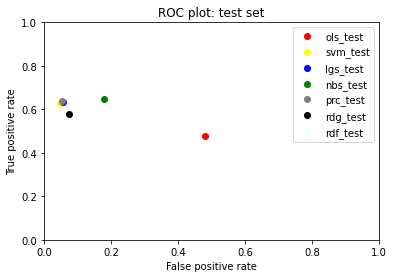

In [50]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
colors = ['red','yellow','blue','green','gray','black','azure']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [25]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./toxiccomments_test.csv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [26]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48483325063330807


In [27]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [28]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,True
3,00017563c3f7919a,True
4,00017695ad8997eb,True


In [29]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation